In [ ]:
n_cpds = 0
file_counts = {}
for sf in pred_files:
    start_time = time.time()
    n_cpds = 0
    x = pd.read_csv(sf)
    x.columns = ['SMILES', 'rf_preds']
    x = x.iloc[:-1,:]
    x.to_csv(sf)
    n_cpds += x.shape[0]
    
    file_counts[sf] = n_cpds
    print('File: {}. # Cpds: {}. Total time: {} minutes'.format(sf.split('\\')[-1],
                                                                n_cpds, 
                                                                (time.time() - start_time)/60.0))

In [5]:
import pandas as pd
import numpy as np
import glob
import time

real_files = ['../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_01.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_02.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_03.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_04.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_05.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_06.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_07.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_08.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_09.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_10.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_11.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_723M_SMILES_Part_12.smiles',
              '../../../datasets/REAL_db\\2019q1-2_Enamine_REAL_Premium_354M_SMILES.smiles']

pred_files = ['../../../datasets/REAL_db_preds\\rf_preds_part_00_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_01_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_02_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_03_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_04_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_05_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_06_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_07_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_08_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_09_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_10_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_11_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_0.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_1.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_2.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_3.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_4.csv.gz',
              '../../../datasets/REAL_db_preds\\rf_preds_part_Premium_process_5.csv.gz']

train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')

train_smiles = train_df['rdkit SMILES'].tolist()
ams_df = pd.read_csv('../datasets/ams_order_results.csv.gz')
ams_smiles = ams_df['rdkit SMILES'].tolist()
real_cols = ['idnumber', 'reagent1', 'reagent2', 'reagent3', 'reagent4', 'reaction',
       'MW', 'sLogP', 'HBA', 'HBD', 'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS',
       'BRENK', 'NIH', 'ZINC', 'LILLY', 'lead-like', '350/3_lead-like',
       'fragments', 'strict_fragments', 'PPI_modulators',
       'natural_product-like']

In [19]:
"""
Read the enamine files and prediction files. 
Double check that smiles are the same.
Keep maintaing top-100k predictions as you process.

"""


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

saltRemover = SaltRemover(defnFilename='../datasets/raw/Salts.txt')
FP_radius=2
FP_size=1024
n_cpds = 0
file_counts = {}
top_df = None
topk = 100000
for rf, pf in zip(real_files[:-1], pred_files[:-6]):
    start_time = time.time()
    n_cpds = 0
    chunksize=2**16
    chunk_pf_df = pd.read_csv(pf, chunksize=chunksize, header=None, skiprows=1)
    chunk_rf_df = pd.read_csv(rf, chunksize=chunksize, header=None, skiprows=1, delimiter='\t', dtype=str)
    for chunk_rf, chunk_pf in zip(chunk_rf_df, chunk_pf_df):
        chunk_pf = chunk_pf.dropna()
        n_cpds += chunk_pf.shape[0]
        
        rf_smiles = chunk_rf[0]
        pf_smiles = chunk_pf[0]
        assert rf_smiles.equals(pf_smiles)

            
        top_idx = np.argsort(chunk_pf.iloc[:,1].values)[::-1][:topk]
        tmp_df = chunk_pf.iloc[top_idx,:].copy()
        tmp_df.columns = ['REAL SMILES', 'rf_preds']
        tmp_df['file'] = rf.split('\\')[-1]
        
        tmp_df2 = chunk_rf.iloc[top_idx,1:].copy()
        tmp_df2.columns = real_cols
        tmp_df = pd.concat([tmp_df, tmp_df2], axis=1)
        if top_df is None:
            top_df = tmp_df
        else:
            top_df = pd.concat([top_df, tmp_df], axis=0)
            top_df = top_df.sort_values('rf_preds', ascending=False).iloc[:topk,:]
    
    file_counts[pf] = n_cpds
    print('File: {}. # Cpds: {}. Total time: {} minutes'.format(pf.split('\\')[-1],
                                                                n_cpds, 
                                                                (time.time() - start_time)/60.0))

# process premium file
rf = real_files[-1]
instances_per_process=60263531
for process_id, pf in enumerate(pred_files[-6:]):
    start_time = time.time()
    n_cpds = 0
    chunksize=2**16
    chunk_pf_df = pd.read_csv(pf, chunksize=chunksize, header=None, skiprows=1)
    chunk_rf_df = pd.read_csv(rf, chunksize=chunksize, header=None, 
                              skiprows=1+process_id*instances_per_process, 
                              nrows=instances_per_process, delimiter='\t', dtype=str)
    for chunk_rf, chunk_pf in zip(chunk_rf_df, chunk_pf_df):
        chunk_pf = chunk_pf.dropna()
        n_cpds += chunk_pf.shape[0]
        
        rf_smiles = chunk_rf[0]
        pf_smiles = chunk_pf[0]
        assert rf_smiles.equals(pf_smiles)

            
        top_idx = np.argsort(chunk_pf.iloc[:,1].values)[::-1][:topk]
        tmp_df = chunk_pf.iloc[top_idx,:].copy()
        tmp_df.columns = ['REAL SMILES', 'rf_preds']
        tmp_df['file'] = rf.split('\\')[-1]+'_{}'.format(process_id)
        
        tmp_df2 = chunk_rf.iloc[top_idx,1:].copy()
        tmp_df2.columns = real_cols
        tmp_df = pd.concat([tmp_df, tmp_df2], axis=1)
        if top_df is None:
            top_df = tmp_df
        else:
            top_df = pd.concat([top_df, tmp_df], axis=0)
            top_df = top_df.sort_values('rf_preds', ascending=False).iloc[:topk,:]
    
    file_counts[pf] = n_cpds
    print('File: {}. # Cpds: {}. Total time: {} minutes'.format(pf.split('\\')[-1],
                                                                n_cpds, 
                                                                (time.time() - start_time)/60.0))

File: rf_preds_part_00_process_0.csv.gz. # Cpds: 60262531. Total time: 23.947564816474916 minutes
File: rf_preds_part_01_process_0.csv.gz. # Cpds: 60262531. Total time: 28.717576165994007 minutes
File: rf_preds_part_02_process_0.csv.gz. # Cpds: 60262531. Total time: 27.71714601914088 minutes
File: rf_preds_part_03_process_0.csv.gz. # Cpds: 60262531. Total time: 25.994003387292228 minutes
File: rf_preds_part_04_process_0.csv.gz. # Cpds: 60262531. Total time: 26.57414681514104 minutes
File: rf_preds_part_05_process_0.csv.gz. # Cpds: 60262531. Total time: 27.704191672801972 minutes
File: rf_preds_part_06_process_0.csv.gz. # Cpds: 60262531. Total time: 27.439516512552895 minutes
File: rf_preds_part_07_process_0.csv.gz. # Cpds: 60262531. Total time: 34.3747727115949 minutes
File: rf_preds_part_08_process_0.csv.gz. # Cpds: 60262531. Total time: 25.95211853981018 minutes
File: rf_preds_part_09_process_0.csv.gz. # Cpds: 60262531. Total time: 26.545506620407103 minutes
File: rf_preds_part_10_pr

In [32]:
"""
Compute PAINS Filter.
Then remove enamine cpds that are also in training or ams datasets.
"""

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

#top_df = pd.read_csv('../datasets/real_top_preds.csv.gz')
col_ord = ['idnumber', 'REAL SMILES', 'rdkit SMILES', 'rf_preds',  '1024 MorganFP Radius 2','PAINS Filter'] + ['reagent1', 'reagent2', 'reagent3', 'reagent4', 'reaction',
       'MW', 'sLogP', 'HBA', 'HBD', 'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS',
       'BRENK', 'NIH', 'ZINC', 'LILLY', 'lead-like', '350/3_lead-like',
       'fragments', 'strict_fragments', 'PPI_modulators',
       'natural_product-like']

FP_radius=2
FP_size=1024
saltRemover = SaltRemover(defnFilename='../datasets/raw/Salts.txt')
rdkit_mols = top_df['REAL SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mols = rdkit_mols.apply((lambda x: saltRemover.StripMol(x)))
top_df['rdkit SMILES'] = rdkit_mols.apply((lambda x: Chem.MolToSmiles(x)))
top_df['1024 MorganFP Radius 2'] = rdkit_mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 
                                                                                       radius=FP_radius, 
                                                                                       nBits=FP_size).ToBitString()))

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
pains_catalog = FilterCatalog(params)

top_df['PAINS Filter'] = rdkit_mols.apply((lambda x: not pains_catalog.HasMatch(x))).astype(int)
top_df = top_df[~top_df['rdkit SMILES'].isin(train_smiles)]
top_df = top_df[~top_df['rdkit SMILES'].isin(ams_smiles)]

In [42]:
col_ord = ['idnumber', 'REAL SMILES', 'rdkit SMILES', 'rf_preds', 'file',
       '1024 MorganFP Radius 2', 'PAINS Filter', 'reagent1', 'reagent2',
       'reagent3', 'reagent4', 'reaction', 'MW', 'sLogP', 'HBA', 'HBD',
       'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS', 'BRENK', 'NIH', 'ZINC',
       'LILLY', 'lead-like', '350/3_lead-like', 'fragments',
       'strict_fragments', 'PPI_modulators', 'natural_product-like']
top_df = top_df[col_ord]

top_df.to_csv('../datasets/enamine_filtering/real_top_{}.csv.gz'.format(top_df.shape[0]), index=False)

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min
train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')
topk = 10000
top_df = pd.read_csv('../datasets/real_top_99674.csv.gz')
top_df = top_df.sort_values('rf_preds', ascending=False)
top_df = top_df.iloc[:topk,:]

X_train = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in train_df['1024 MorganFP Radius 2']]).astype(float)
X_real = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in top_df['1024 MorganFP Radius 2']]).astype(float)
closest_idx, closest_dist = pairwise_distances_argmin_min(X_real, X_train, metric='jaccard')
closest_train_idx = train_df['Molecule ID'].iloc[closest_idx].values
top_df['Closest Training ID'] = closest_train_idx
top_df['Closest Training TanDist'] = closest_dist

col_ord = ['idnumber', 'REAL SMILES', 'rdkit SMILES', 'rf_preds', 'file',
       '1024 MorganFP Radius 2', 'PAINS Filter', 'reagent1', 'reagent2',
       'reagent3', 'reagent4', 'reaction', 'MW', 'sLogP', 'HBA', 'HBD',
       'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS', 'BRENK', 'NIH', 'ZINC',
       'LILLY', 'lead-like', '350/3_lead-like', 'fragments',
       'strict_fragments', 'PPI_modulators', 'natural_product-like',
       'Closest Training ID', 'Closest Training TanDist']
top_df = top_df[col_ord]
top_df.to_csv('../datasets/real_top_{}.csv.gz'.format(topk), index=False)

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversion

In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')
top_df = pd.read_csv('../datasets/real_top_10000.csv.gz')
ams_df = pd.read_csv('../datasets/ams_order_results.csv.gz')

des_cols = ['Index ID', '1024 MorganFP Radius 2']
x = pd.concat([train_df[des_cols], ams_df[des_cols], top_df[des_cols]])
x.to_csv('../datasets/real_clustering.csv.gz')

---
# Timing Estimates

In [141]:
import glob 

log_dir = '../../../datasets/REAL_db_preds/logs/*.out'
logs = glob.glob(log_dir)

datalist = []
for lf in logs:
    with open(lf, 'r') as f:
        content = f.readlines()
    
    timeline = content[5].split(' ')
    filename = content[6][2:][:-5]
    
    minutes = float(timeline[2])
    hours = minutes / 60.0
    cpd_count = int(timeline[-2])
    
    datalist.append([filename, minutes, hours, cpd_count])


time_df = pd.DataFrame(datalist, 
                       columns=['File', 'Minutes', 'Hours', '# compounds']).sort_values('File')

time_df['Part'] = np.arange(time_df.shape[0])
time_df = time_df.append(pd.DataFrame([['mean', time_df['Minutes'].mean(),  time_df['Hours'].mean(), time_df['# compounds'].mean(), 'mean']], 
                            columns=time_df.columns))
time_df = time_df.append(pd.DataFrame([['std', time_df['Minutes'].std(),  time_df['Hours'].std(), time_df['# compounds'].std(), 'std']], 
                            columns=time_df.columns))

time_df['Hours'] = time_df['Hours'].round(decimals=2)
time_df['Minutes'] = time_df['Minutes'].round(decimals=2)

In [151]:

x = time_df[['Part', 'Hours', '# compounds']].copy()
x['# compounds'] = x['# compounds'].astype(int)
print(x.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
 Part &  Hours &  \# compounds \\
\midrule
    0 &  50.83 &     60262531 \\
    1 &  63.71 &     60262531 \\
    2 &  46.62 &     60262531 \\
    3 &  45.81 &     60262531 \\
    4 &  63.43 &     60262531 \\
    5 &  63.70 &     60262531 \\
    6 &  51.81 &     60262531 \\
    7 &  64.35 &     60262531 \\
    8 &  49.12 &     60262531 \\
    9 &  49.86 &     60262531 \\
   10 &  52.74 &     60262531 \\
   11 &  46.51 &     60262530 \\
   12 &  54.52 &     60263531 \\
   13 &  49.47 &     60263531 \\
   14 &  47.12 &     60263531 \\
   15 &  55.65 &     60263531 \\
   16 &  55.88 &     60263531 \\
   17 &  46.63 &     53094961 \\
 mean &  53.21 &     59864610 \\
  std &   6.40 &      1641881 \\
\bottomrule
\end{tabular}



---
# REAL Top-k

In [2]:
import pandas as pd
import numpy as np
import glob

train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')
top_df = pd.read_csv('../datasets/real_top_10000.csv.gz')
ams_df = pd.read_csv('../datasets/ams_order_results.csv.gz')
clustering = pd.read_csv('../datasets/real_clustering.csv.gz')

real_costs = pd.read_csv('../datasets/real_costs_2020_03_13.csv')
real_costs_2 = pd.read_csv('../datasets/premium_1536_costs.csv')

In [3]:
real_costs.shape, real_costs_2.shape

((4984, 13), (1539, 7))

In [ ]:
#cluster_assigment_vector = np.memmap('../datasets/cluster_assigment_vector_{}.dat'.format(0.4), 
#                                         dtype='int32', mode='r', shape=(clustering.shape[0],))
#cluster_leader_idx_vector = np.memmap('../datasets/cluster_leader_idx_vector_{}.dat'.format(0.4), 
#                                      dtype='int32', mode='r', shape=(clustering.shape[0],))
#clustering['TB_0.4 ID'] = cluster_assigment_vector
#clustering['TB_0.4 Leader'] = cluster_leader_idx_vector

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

saltRemover = SaltRemover(defnFilename='../datasets/raw/Salts.txt')
rdkit_mols = real_costs['SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mols = rdkit_mols.apply((lambda x: saltRemover.StripMol(x)))
smiles = rdkit_mols.apply((lambda x: Chem.MolToSmiles(x)))
real_costs['rdkit SMILES'] = smiles

rdkit_mols = real_costs_2['SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mols = rdkit_mols.apply((lambda x: saltRemover.StripMol(x)))
smiles = rdkit_mols.apply((lambda x: Chem.MolToSmiles(x)))
real_costs_2['rdkit SMILES'] = smiles

In [63]:
merge_smile = pd.merge(top_df, real_costs, left_on='rdkit SMILES', right_on='rdkit SMILES', suffixes=['', '_y'])
merge_id = pd.merge(top_df, real_costs, left_on='idnumber', right_on='ID Enamine', suffixes=['', '_y'])

merge_smile.shape, merge_id.shape, merge_id[merge_id['idnumber'].isin(merge_smile['idnumber'])].shape

((4084, 47), (4085, 48), (4084, 48))

In [64]:
np.setdiff1d(merge_id['idnumber'], merge_smile['idnumber'])

array(['Z2852349376'], dtype=object)

In [132]:
print(merge_id[merge_id['idnumber'] == 'Z2852349376'][['idnumber', 'rdkit SMILES', 'ID Enamine', 'rdkit SMILES_y']])

         idnumber                            rdkit SMILES   ID Enamine  \
3312  Z2852349376  FC(F)C1CC(Nc2nc(-c3ccccn3)nc3c2CCC3)C1  Z2852349376   

                              rdkit SMILES_y  
3312  c1ccc(-c2nc3c(c(NCC4CSCCN4)n2)CCC3)nc1  


In [70]:
merge_smile = merge_smile.drop(['SMILES', 'MW_y'], axis=1)
top_real_clustering = pd.merge(merge_smile, clustering, left_on='Index ID', right_on='Index ID', suffixes=['', '_y'])
top_real_clustering = top_real_clustering.drop(['1024 MorganFP Radius 2_y'], axis=1)

In [101]:
ams_clusters = clustering[clustering['dataset'] == 'ams']
train_clusters = clustering[clustering['dataset'] == 'train']
tr_clusters = top_real_clustering['TB_0.4 ID'].values

exists_in_ams = np.intersect1d(tr_clusters, ams_clusters['TB_0.4 ID'].values)
ams_active_clusters = exists_in_ams[ams_clusters.groupby('TB_0.4 ID').sum()['Hit'].loc[exists_in_ams] > 0]
exists_in_train = np.intersect1d(tr_clusters, train_clusters['TB_0.4 ID'].values)
train_active_clusters = exists_in_train[train_clusters.groupby('TB_0.4 ID').sum()['Hit'].loc[exists_in_train] > 0]

top_real_clustering['Is Train cluster?'] = 0
top_real_clustering['Is Train active cluster?'] = 0
top_real_clustering['Is AMS cluster?'] = 0
top_real_clustering['Is AMS active cluster?'] = 0

top_real_clustering.loc[top_real_clustering['TB_0.4 ID'].isin(exists_in_train),'Is Train cluster?'] = 1
top_real_clustering.loc[top_real_clustering['TB_0.4 ID'].isin(train_active_clusters),'Is Train active cluster?'] = 1
top_real_clustering.loc[top_real_clustering['TB_0.4 ID'].isin(exists_in_ams),'Is AMS cluster?'] = 1
top_real_clustering.loc[top_real_clustering['TB_0.4 ID'].isin(ams_active_clusters),'Is AMS active cluster?'] = 1

In [76]:
top_real_clustering.columns

Index(['idnumber', 'REAL SMILES', 'rdkit SMILES', 'rf_preds', 'file', '1024 MorganFP Radius 2', 'PAINS Filter', 'reagent1', 'reagent2', 'reagent3', 'reagent4', 'reaction', 'MW', 'sLogP', 'HBA', 'HBD', 'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS', 'BRENK', 'NIH', 'ZINC', 'LILLY', 'lead-like', '350/3_lead-like', 'fragments', 'strict_fragments', 'PPI_modulators', 'natural_product-like', 'Closest Training ID', 'Closest Training TanDist', 'Index ID', 'TB_0.4 ID', 'TB_0.4 Leader', 'Hit', 'Is Train cluster?', 'Is Train active cluster?', 'Is AMS cluster?', 'Is AMS active cluster?', 'ID Enamine', 'Amount, mg', 'Price for 1-10 cmpds', 'Price for 11-50 cmpds', 'Price for 20-29 cmpds', 'Price for 30-39 cmpds', 'Price for 40-49 cmpds', 'Status', 'Delivery term, weeks'], dtype='object')

In [75]:
import pandas as pd
import numpy as np

top_real_clustering = pd.read_csv('../datasets/real_costs_clustered_v2.csv.gz')

des_cols = ['ID Enamine', 'PAINS Filter', 
               'TB_0.4 ID', 'Hit', 'Is Train cluster?',
               'Is Train active cluster?', 'Is AMS cluster?',
               'Is AMS active cluster?', 'Closest Training ID', 'Closest Training TanDist', 'rf_preds']

df = top_real_clustering[des_cols].sort_values('rf_preds', ascending=False)
df['rf_rank'] = df['rf_preds'].rank(method='first', ascending=False)

# get cpds in clusters that don't exist in train or ams clusters
new_clusters = df[(df['Is Train cluster?'] == 0) & (df['Is AMS cluster?'] == 0)]
# get highest prediction from each cluster
new_clusters.drop_duplicates(subset='TB_0.4 ID', keep='first')

,ID Enamine,PAINS Filter,TB_0.4 ID,Hit,Is Train cluster?,Is Train active cluster?,Is AMS cluster?,Is AMS active cluster?,Closest Training ID,Closest Training TanDist,rf_preds,rf_rank
19,Z1679904939,1,30617,NaN,0,0,0,0,272513,0.042553,0.504500,20.0
26,Z1881593219,1,2,NaN,0,0,0,0,411173,0.274510,0.480000,27.0
50,Z1437862644,1,236,NaN,0,0,0,0,261647,0.226415,0.441000,51.0
103,Z3295052620,1,262,NaN,0,0,0,0,411173,0.395833,0.397000,104.0
126,Z71174455,1,15867,NaN,0,0,0,0,48572,0.342105,0.386996,127.0
130,Z71172989,1,1030,NaN,0,0,0,0,407710,0.255814,0.385999,131.0
131,Z3515154626,1,8408,NaN,0,0,0,0,194228,0.384615,0.385748,132.0
146,Z3247534314,1,56725,NaN,0,0,0,0,112082,0.411765,0.378250,147.0
171,Z2628381509,1,3116,NaN,0,0,0,0,21588,0.454545,0.371750,172.0
193,Z71174476,1,40673,NaN,0,0,0,0,277447,0.156863,0.363750,194.0


In [1]:
import pandas as pd
import numpy as np

top_real_clustering = pd.read_csv('../datasets/real_costs_clustered_v3.csv.gz')
train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')

des_cols = ['ID Enamine', 'PAINS Filter', 
               'TB_0.4 ID', 'dataset', 'Hit', 'Is Train cluster?',
               'Is Train active cluster?', 'Is AMS cluster?',
               'Is AMS active cluster?', 'rf_preds']

In [10]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from IPython.core.display import HTML
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
    
PandasTools.RenderImagesInAllDataFrames(images=True)
DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0

def show(df): # see issue: https://github.com/rdkit/rdkit/issues/2673
    return HTML(df.to_html())

def get_sim_df(train_df, prosp_df):
    X_train_actives = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in train_df['1024 MorganFP Radius 2']]).astype(float)
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prosp_df['1024 MorganFP Radius 2']]).astype(float)
    train_prosp_tandist = pairwise_distances(X_prosp, X_train_actives, metric='jaccard')
    sim_info = []
    for i in range(train_prosp_tandist.shape[0]):
        prosp_smiles = prosp_df['rdkit SMILES'].iloc[i]; prosp_mol = Chem.MolFromSmiles(prosp_smiles);
        closest_active_idx = np.argmin(train_prosp_tandist[i,:]); 
        dist = train_prosp_tandist[i,closest_active_idx]
        train_smiles = train_df['rdkit SMILES'].iloc[closest_active_idx]; train_mol = Chem.MolFromSmiles(train_smiles);
        
        # try to align mols
        try:
            mcs = rdFMCS.FindMCS([train_mol, prosp_mol], ringMatchesRingOnly=True, completeRingsOnly=True)
            template = Chem.MolFromSmarts(mcs.smartsString)
            AllChem.Compute2DCoords(template)
            AllChem.GenerateDepictionMatching2DStructure(train_mol, template)
            AllChem.GenerateDepictionMatching2DStructure(prosp_mol, template)
        except:
            pass
        
        sim_info.append((prosp_mol, train_mol, dist, prosp_df['rf_preds'].iloc[i]))
        
    sim_df = pd.DataFrame(data=sim_info, 
                          columns=['Prospective Mol', 'Closest Training Active', 'Tanimoto Distance', 'RF-C Score'])
    sim_df = sim_df.sort_values('RF-C Score', ascending=False).reset_index(drop=True)
    return sim_df

train_actives = train_df[train_df['PriA-SSB AS Activity'] == 1]
sim_df = get_sim_df(train_actives, top_real_clustering)
sim_df['RF-C Rank'] = sim_df['RF-C Score'].rank(method='first', ascending=False).astype(int)

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\Moeman\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,Prospective Mol,Closest Training Active,Tanimoto Distance,RF-C Score
0,,,0.000000,0.871750
1,,,0.000000,0.871750
2,,,0.000000,0.651750
3,,,0.052632,0.641496
4,,,0.000000,0.628750
5,,,0.000000,0.628750
6,,,0.122807,0.619750
7,,,0.158730,0.593000
8,,,0.212766,0.576000
9,,,0.142857,0.572000

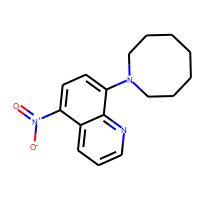
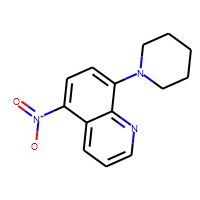
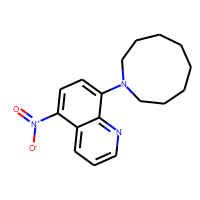
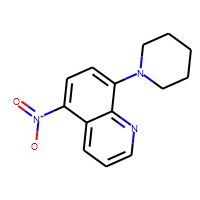
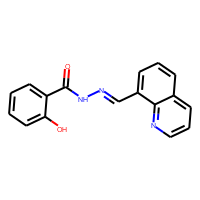
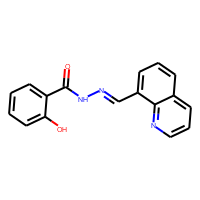
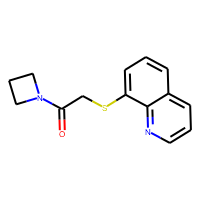
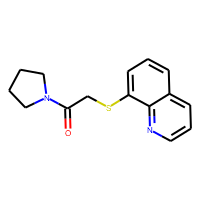
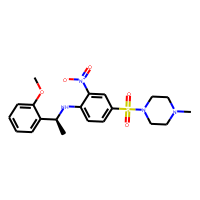
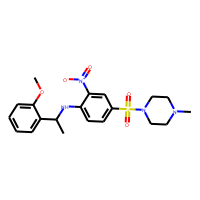
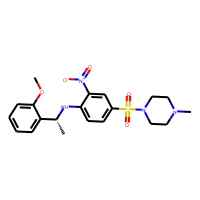
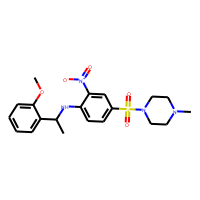
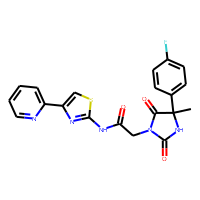
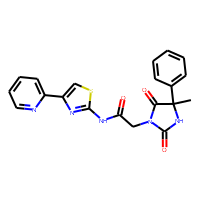
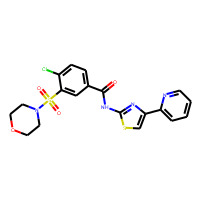
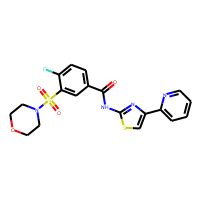
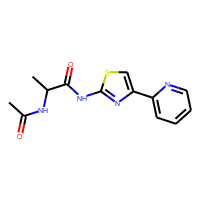
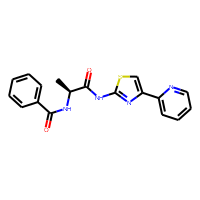
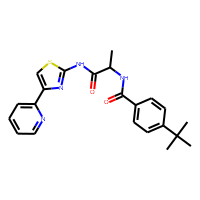
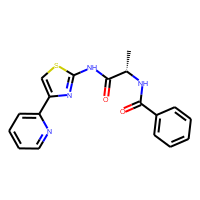

In [11]:
show(sim_df.iloc[:10,:-1])

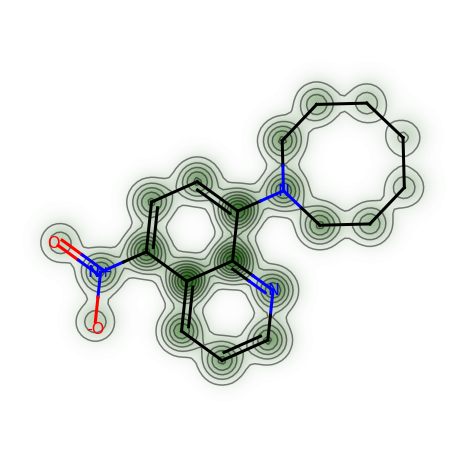

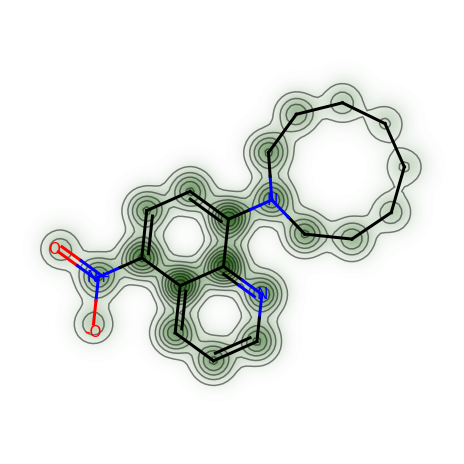

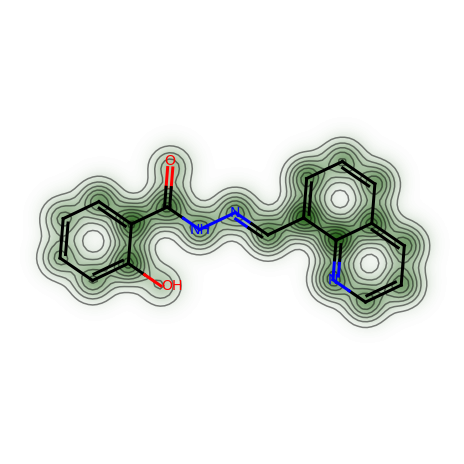

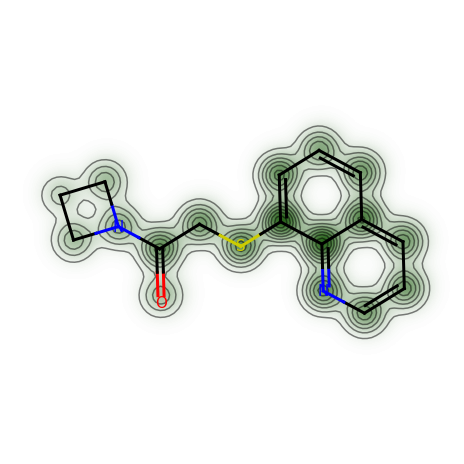

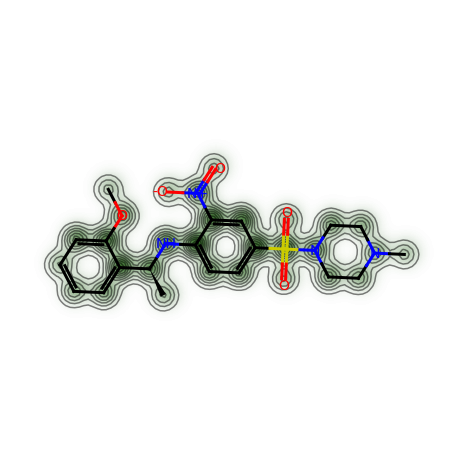

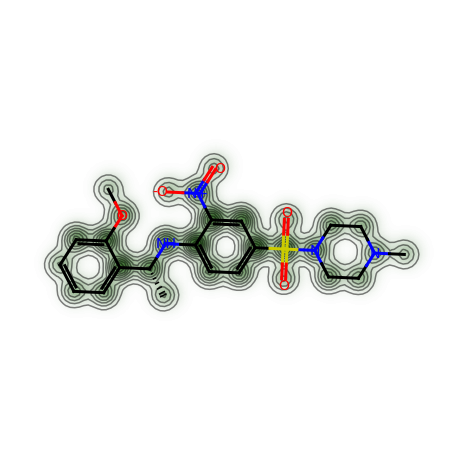

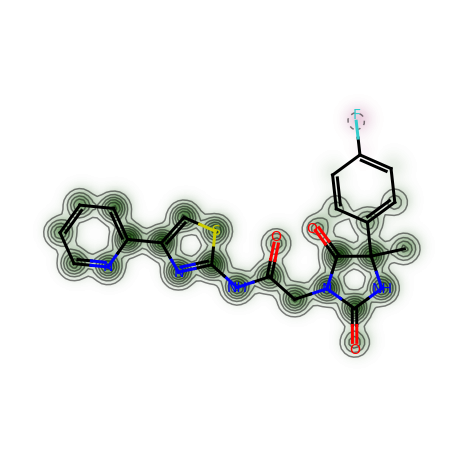

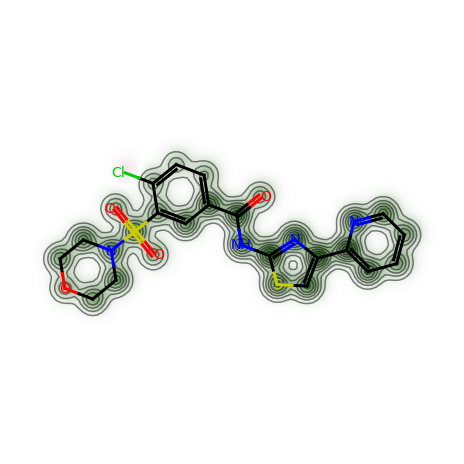

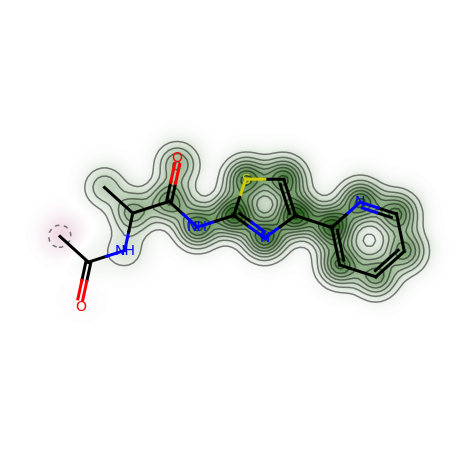

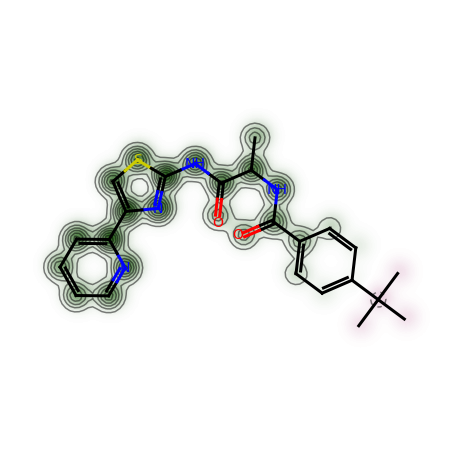

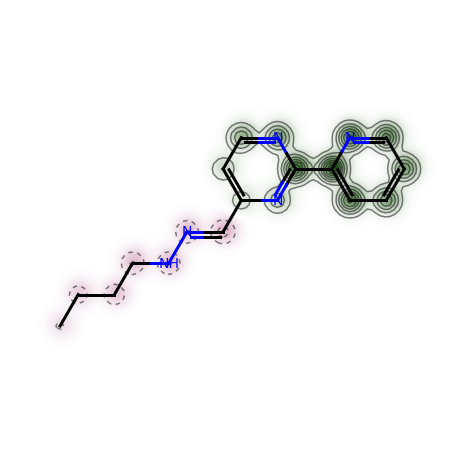

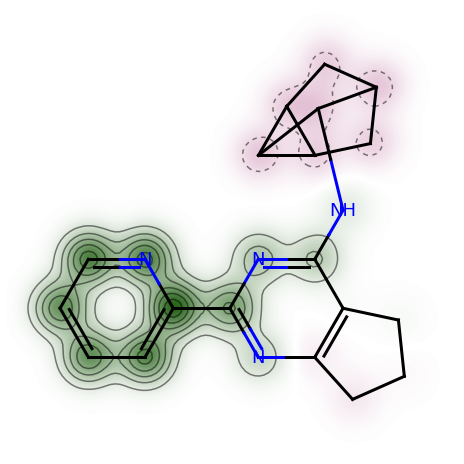

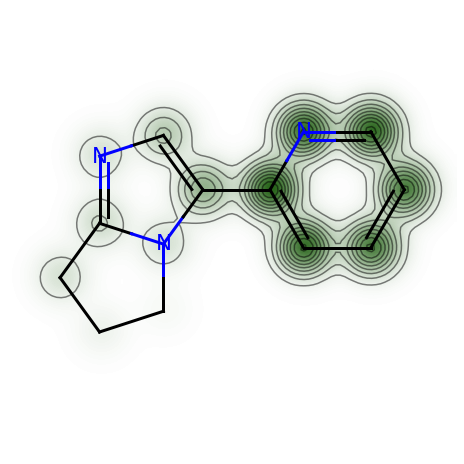

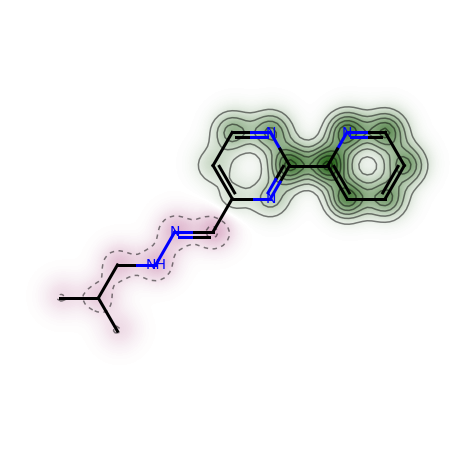

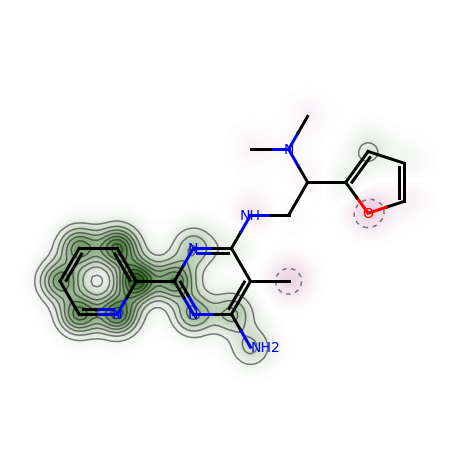

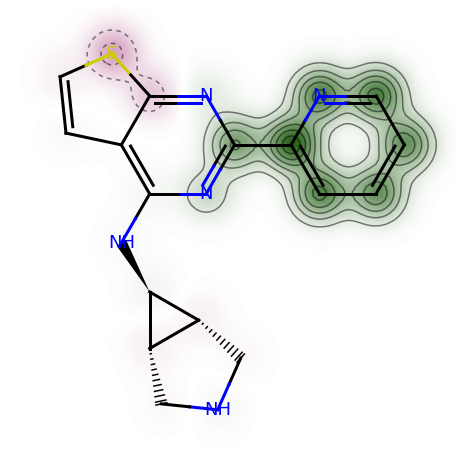

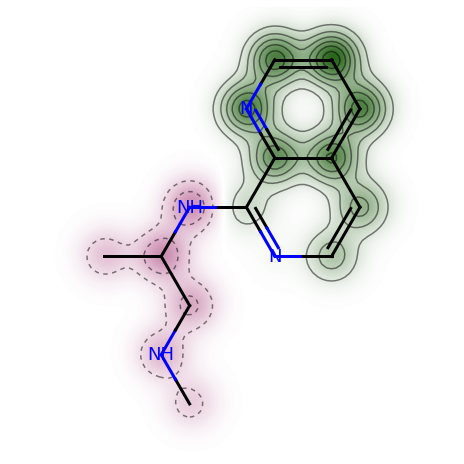

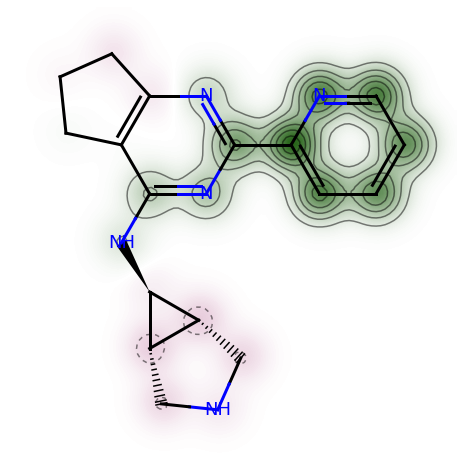

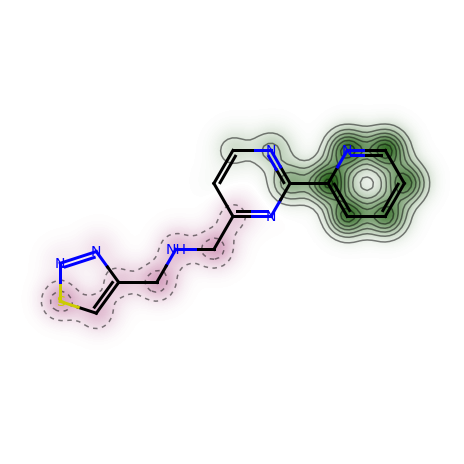

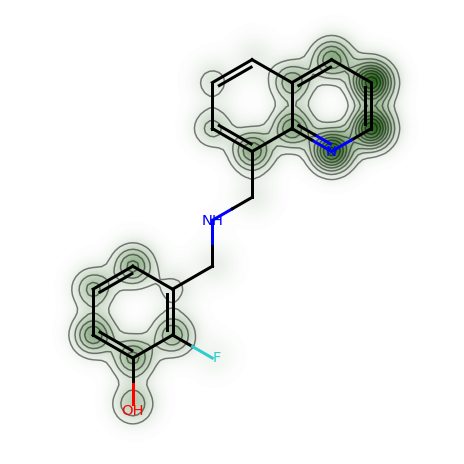

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
FP_radius=2
x = sim_df.iloc[:10,:-1].copy()

for i in range(x.shape[0]):
    Draw.MolToFile(x.iloc[i,0], "./real_vis/rf_{}{}.png".format(i, 0))
    Draw.MolToFile(x.iloc[i,1], "./real_vis/rf_{}{}.png".format(i, 1))
    
    prosp_mol = x.iloc[i,0]
    train_mol = x.iloc[i,1]
    
    sim_func = (lambda a, b: SimilarityMaps.GetMorganFingerprint(a, atomId=b, fpType='bv', radius=FP_radius, nBits=1024))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train_mol, prosp_mol, sim_func)
        
    fig.savefig("./real_vis/rf_{}{}.png".format(i, 3), bbox_inches='tight')
    
y = sim_df.sort_values('Tanimoto Distance', ascending=False).iloc[:10,:].copy()

for i in range(y.shape[0]):
    Draw.MolToFile(y.iloc[i,0], "./real_vis_tandist/rf_{}{}.png".format(i, 0))
    Draw.MolToFile(y.iloc[i,1], "./real_vis_tandist/rf_{}{}.png".format(i, 1))
    
    prosp_mol = y.iloc[i,0]
    train_mol = y.iloc[i,1]
    
    sim_func = (lambda a, b: SimilarityMaps.GetMorganFingerprint(a, atomId=b, fpType='bv', radius=FP_radius, nBits=1024))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train_mol, prosp_mol, sim_func)
        
    fig.savefig("./real_vis_tandist/rf_{}{}.png".format(i, 3), bbox_inches='tight')

In [110]:
x['Prospective Mol'] = ''
x['Closest Training Active'] = ''

print(x.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Prospective Mol & Closest Training Active &  Tanimoto Distance &  RF-C Score \\
\midrule
                &                         &           0.000000 &    0.871750 \\
                &                         &           0.000000 &    0.871750 \\
                &                         &           0.000000 &    0.651750 \\
                &                         &           0.052632 &    0.641496 \\
                &                         &           0.000000 &    0.628750 \\
                &                         &           0.000000 &    0.628750 \\
                &                         &           0.122807 &    0.619750 \\
                &                         &           0.158730 &    0.593000 \\
                &                         &           0.212766 &    0.576000 \\
                &                         &           0.142857 &    0.572000 \\
\bottomrule
\end{tabular}



In [111]:
y['Prospective Mol'] = ''
y['Closest Training Active'] = ''

print(y.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Prospective Mol & Closest Training Active &  Tanimoto Distance &  RF-C Score &  RF-C Rank \\
\midrule
                &                         &           0.627451 &    0.180500 &       4981 \\
                &                         &           0.622951 &    0.199000 &       3637 \\
                &                         &           0.620000 &    0.194499 &       3933 \\
                &                         &           0.620000 &    0.195750 &       3852 \\
                &                         &           0.616667 &    0.176250 &       5348 \\
                &                         &           0.612245 &    0.173750 &       5615 \\
                &                         &           0.611111 &    0.177496 &       5262 \\
                &                         &           0.610169 &    0.197500 &       3740 \\
                &                         &           0.609756 &    0.182500 &       4821 \\
                &            

,Prospective Mol,Closest Training Active,Tanimoto Distance,RF-C Score,RF-C Rank
4980,,,0.627451,0.180500,4981
3636,,,0.622951,0.199000,3637
3932,,,0.620000,0.194499,3933
3851,,,0.620000,0.195750,3852
5347,,,0.616667,0.176250,5348
5614,,,0.612245,0.173750,5615
5261,,,0.611111,0.177496,5262
3739,,,0.610169,0.197500,3740
4820,,,0.609756,0.182500,4821
5308,,,0.607843,0.176750,5309

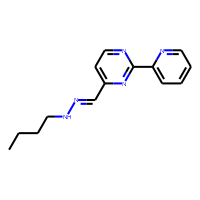
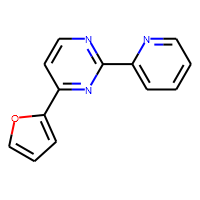
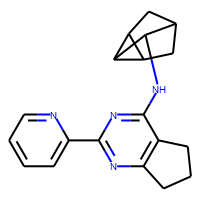
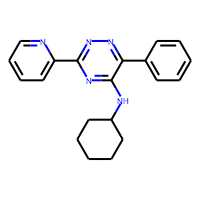
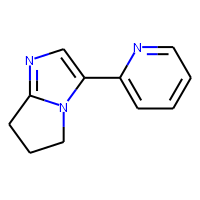
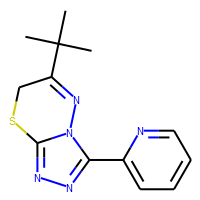
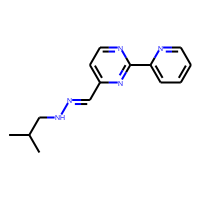
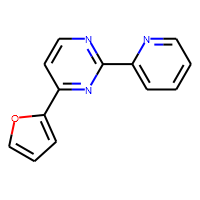
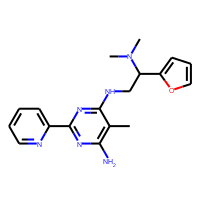
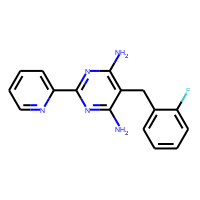
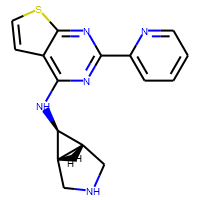
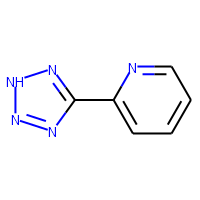
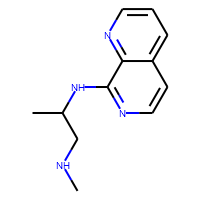
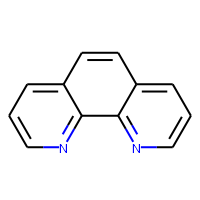
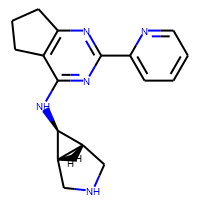
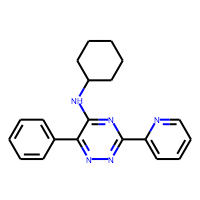
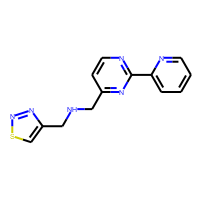
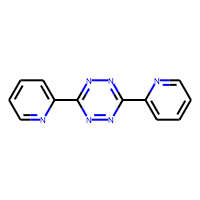
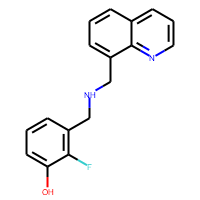
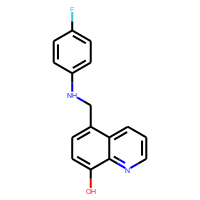

In [13]:
show(y)

In [102]:
fig.savefig('./real_vis/x.png')

In [11]:
x = pd.read_csv('../datasets/Zenodo/v1/train_ams_real_cluster.csv.gz')
x

,Index ID,1024 MorganFP Radius 2,TB_0.4 ID,TB_0.4 Leader,dataset,Hit
0,0,0100000000000000000000000110000001000010000000...,40724,0,train,0.0
1,1,0000100000000000000000000000010001000000000000...,35835,179687,train,0.0
2,2,0000000000000000000000000000000001000001000000...,22125,251840,train,0.0
3,3,0000000000000001000000010000000001000000000000...,56822,3,train,0.0
4,4,0000000000000001000000010000000001000000000000...,56823,4,train,0.0
5,5,0001000000000000000000000000000001000000000000...,56824,5,train,0.0
6,6,0001000000000000000000000000000000000000000100...,56825,6,train,0.0
7,7,0000000000000000000000000000000000100000000000...,56826,7,train,0.0
8,8,0000000000000001000000000000000001000000000000...,56827,8,train,0.0
9,9,0000000000000010000000000000000000000000000000...,56828,9,train,0.0
